# AutoEncoder

어제 다뤘던 이동통신 고객 이탈 데이터를 이용하여, AE 모델을 생성하고 예측해 봅시다. 



## 1.환경준비

### 1) 라이브러리 로딩

In [22]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import precision_recall_curve

from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense
from keras.backend import clear_session
from keras.optimizers import Adam

### 2) 필요 함수들 생성

#### ① reconstruction error plot

> * input과 output의 차이(mse)를 계산하고
* 시각화 합니다.



In [23]:
def recon_err_plot(x, x_pred, y, threshold=0):
    # treshold : 우리가 지정해줘야 함.(어떻게?)
    
    mse = np.mean(np.power(x - x_pred, 2), axis=1)
    error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': y})
    error_df = error_df.reset_index()

    groups = error_df.groupby('True_class')
    fig, ax = plt.subplots()
    for name, group in groups:
        ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
                label= "Abnormal" if name == 1 else "Normal")
    ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
    ax.legend()
    plt.title("Reconstruction error for different classes")
    plt.ylabel("Reconstruction error")
    plt.xlabel("Data point index")
    plt.show()

    return error_df

#### ② precision, recall, f1 curve

> * sklearn에서는 precision, recall curve만 제공됩니다. 
* 그래서, f1 curve도 추가해서 구하고, plot을 그립니다.



In [24]:
def prec_rec_f1_curve(y, score, pos = 1) :
    precision, recall, thresholds  = precision_recall_curve(y, score, pos_label=1)
    f1 = 2 / (1/precision + 1/recall)

    plt.figure(figsize = (12,8))
    plt.plot(thresholds, np.delete(precision, -1), label = 'precision')
    plt.plot(thresholds, np.delete(recall, -1), label = 'recall')
    plt.plot(thresholds, np.delete(f1, -1), label = 'f1')
    plt.xlabel('Anomaly Score')
    plt.legend()
    plt.grid()
    plt.show()

    return precision, recall, f1, thresholds

#### ③ threshold로 잘랐을 때, 분류 평가 함수


In [25]:
from sklearn.metrics import confusion_matrix, classification_report

def classification_report2(y, pred, thresholds):
    pred_temp = np.where(pred > thresholds , 1, 0)

    print('< confusion matrix >\n')
    print(confusion_matrix(y, pred_temp))
    print('\n' + '='*60 + '\n')

    print('< classification_report >\n')
    print(classification_report(y, pred_temp))

#### ④ DL 학습곡선 그리기


In [26]:
def plot_learning_curve(history) :
    plt.figure(figsize = (10,6))
    plt.plot(history['loss'], label='Train', marker = '.')
    plt.plot(history['val_loss'], label='Validation', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

### 3) 데이터셋 불러오기

In [27]:
# secom
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/secom_9.csv"
data = pd.read_csv(path)

data['label'] = 0
data.loc[data['defeat']== 'defeat', 'label']= 1
data.drop(['datetime','defeat'], axis = 1, inplace=True)

target = 'label'
x = data.drop(target, axis = 1)
y = data.loc[:,target]

In [28]:
data.shape

(1567, 53)

In [ ]:
data.head()

In [30]:
y.value_counts()

0    1463
1     104
Name: label, dtype: int64

In [31]:
y.value_counts() / y.shape[0]

0    0.933631
1    0.066369
Name: label, dtype: float64

## 2.데이터 준비

* 분할

In [32]:
x.shape

(1567, 52)

In [33]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .2, random_state=20)

In [34]:
x_train.shape, y_train.shape

((1253, 52), (1253,))

* 스케일링

In [35]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

* Normal 데이터만 뽑기

In [36]:
# 학습을 위해서는 Normal 데이터만 이용한다.
x_train0 = x_train[y_train == 0]

In [37]:
x_train0.shape

(1165, 52)

## 3.모델링 : AE

### 1) 학습

* 모델 설계

In [38]:
input_dim = x_train0.shape[1]
input_dim

52

In [39]:
input_dim = x_train0.shape[1] #num of columns

clear_session()
autoencoder = Sequential([Dense(32, input_shape = (input_dim,), activation = 'relu'),
                          Dense(16, activation="relu"),
                          Dense(32, activation='relu'),
                          Dense(input_dim, activation='relu')])

autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                1696      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 32)                544       
                                                                 
 dense_3 (Dense)             (None, 52)                1716      
                                                                 
Total params: 4,484
Trainable params: 4,484
Non-trainable params: 0
_________________________________________________________________


* compile + 학습

In [ ]:
autoencoder.compile(optimizer='adam', loss='mse')

history = autoencoder.fit(x=x_train0, y=x_train0,
                          epochs=50, batch_size=64,
                          validation_split = .2).history

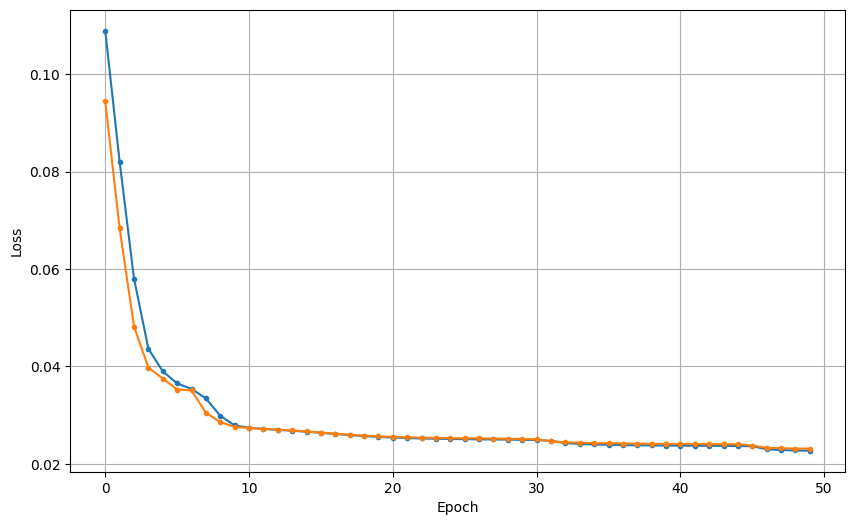

In [41]:
plot_learning_curve(history)

### 2) 예측 및 Reconstruction Error 계산

#### ① 예측

In [42]:
pred = autoencoder.predict(x_val)
pred

10/10 [==============================] - 0s 4ms/step


array([[0.75692123, 0.55380994, 0.9045989 , ..., 0.        , 0.        ,
        0.        ],
       [0.8213758 , 0.47076848, 0.9009193 , ..., 0.        , 0.        ,
        0.        ],
       [0.8700641 , 0.6279831 , 1.0473195 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.8493875 , 0.51497465, 0.9512683 , ..., 0.        , 0.        ,
        0.        ],
       [0.84426284, 0.46896407, 0.91482186, ..., 0.        , 0.        ,
        0.        ],
       [0.8376839 , 0.52006775, 0.9573045 , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

#### ② 재구성 오차 계산

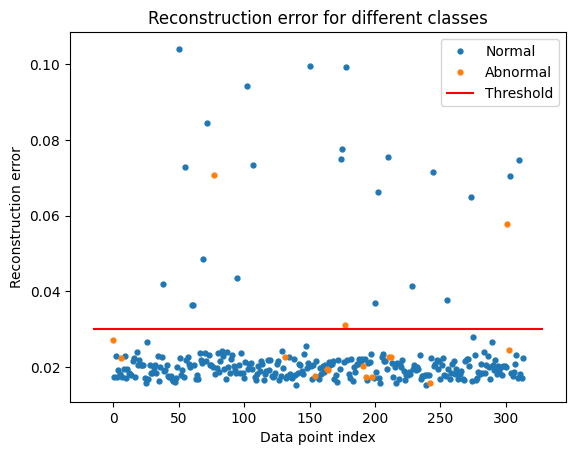

In [43]:
result = recon_err_plot(x_val, pred, y_val, .03)

In [44]:
result.head()

,index,Reconstruction_error,True_class
0,1227,0.027206,1
1,545,0.017211,0
2,1013,0.022910,0
3,1281,0.017331,0
4,522,0.019066,0


#### ③ Threshold 찾기 : precision_recall_f1_curve

<ipython-input-24-54b2435d894a>:3: RuntimeWarning: divide by zero encountered in true_divide
  f1 = 2 / (1/precision + 1/recall)


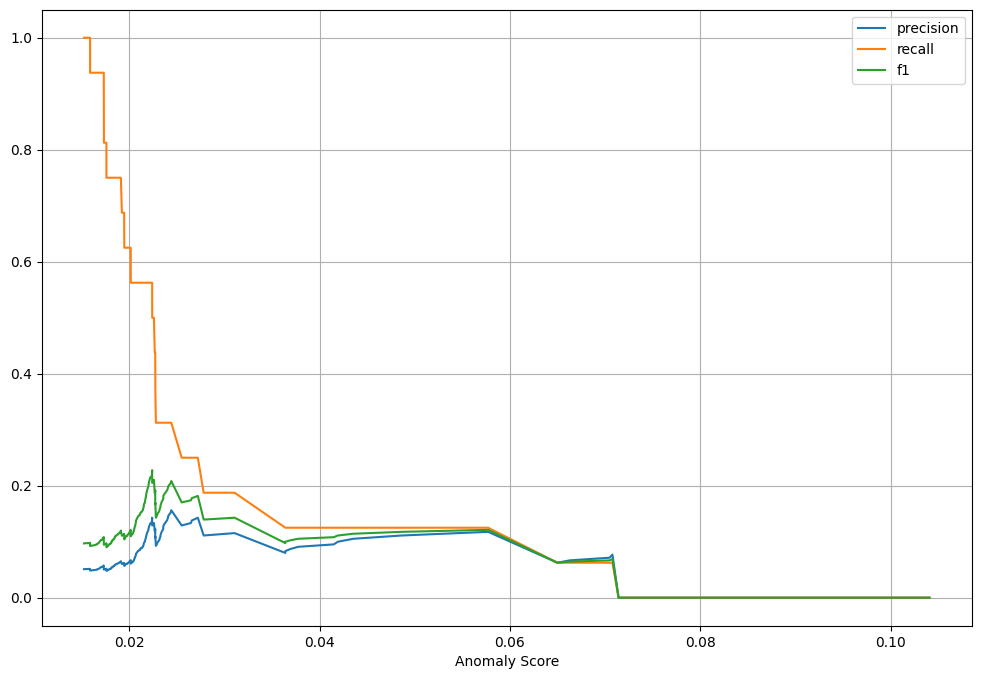

In [45]:
precision, recall, f1, thresholds = prec_rec_f1_curve(result['True_class'], result['Reconstruction_error'])

In [46]:
thres_f1_max = thresholds[np.argmax(f1)]
thres_f1_max

0.022407144890218056

#### ④ f1을 최대화 하는 threshold 값으로 잘라서 평가

In [47]:
classification_report2(result['True_class'], result['Reconstruction_error'], thres_f1_max)

< confusion matrix >

[[244  54]
 [  8   8]]


< classification_report >

              precision    recall  f1-score   support

           0       0.97      0.82      0.89       298
           1       0.13      0.50      0.21        16

    accuracy                           0.80       314
   macro avg       0.55      0.66      0.55       314
weighted avg       0.93      0.80      0.85       314



## 4.실습 : 사기거래 탐지

### 1) 데이터셋 불러오기

* 데이터 로딩

In [48]:
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/creditcard_simple.csv"
data = pd.read_csv(path)

target = 'fraud'
x = data.drop(target, axis = 1)
y = data.loc[:,target]

In [49]:
data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,amount,fraud
0,0.733,-0.544,-0.601,0.020,0.181,0.172,-1.768,-0.083,-0.323,0.110,-0.019,-0.457,-0.088,0.167,0.270,-0.513,-0.006,0.044,199.45,0
1,1.942,-0.056,1.319,1.197,0.367,0.265,0.006,0.310,-0.522,-0.223,-0.268,-0.595,0.345,-1.040,-0.432,0.280,-0.018,-0.057,1.98,0
2,-0.223,1.182,0.166,-1.328,0.151,-0.101,-0.489,0.476,0.034,-0.174,0.404,1.288,-0.076,0.071,-0.787,-0.218,0.382,0.259,0.89,0
3,0.672,-1.261,-0.602,-0.866,-0.335,0.875,0.786,0.012,1.338,0.655,0.201,0.078,-0.527,0.133,0.745,0.041,-0.074,0.049,340.31,0
4,-3.368,0.099,0.458,-1.572,0.672,-3.188,1.019,-0.590,1.930,0.265,0.861,1.249,1.851,-0.117,1.220,0.000,1.036,0.004,320.01,1


In [50]:
y.value_counts()

0    19508
1      492
Name: fraud, dtype: int64

In [51]:
y.value_counts() / y.shape[0]

0    0.9754
1    0.0246
Name: fraud, dtype: float64

* 데이터 분할

In [52]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 6000, random_state=2022)

* 스케일링

In [53]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

* Normal 데이터만 저장

In [57]:
x_train0 = x_train[y_train == 0]

### 2) 모델링 : AE

#### ① 학습

* 모델 설계
    * 아래 구조를 참조하되 여러분이 원하는 대로 생성을 해 봅시다.

_________________________________________________________________
 Layer (type)                Output Shape              
_________________________________________________________________
dense (Dense)               (None, 32)                     
                                                                 
 dense_1 (Dense)             (None, 16)                     
                                                                 
 dense_2 (Dense)             (None, 8)                      
                                                                 
 dense_3 (Dense)             (None, 16)                     
                                                                 
 dense_4 (Dense)             (None, 32)                     
                                                                 
 dense_5 (Dense)             (None, 19)                     
_________________________________________________________________


In [59]:
input_dim = x_train.shape[1]
input_dim

19

In [60]:
model = Sequential([Dense(32, input_shape = (input_dim,), activation='relu'),
                    Dense(16, activation = 'relu'),
                    Dense(8, activation = 'relu'),
                    Dense(16, activation = 'relu'),
                    Dense(32, activation = 'relu'),
                    Dense(input_dim, activation = 'relu') ] )
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                640       
                                                                 
 dense_5 (Dense)             (None, 16)                528       
                                                                 
 dense_6 (Dense)             (None, 8)                 136       
                                                                 
 dense_7 (Dense)             (None, 16)                144       
                                                                 
 dense_8 (Dense)             (None, 32)                544       
                                                                 
 dense_9 (Dense)             (None, 19)                627       
                                                                 
Total params: 2,619
Trainable params: 2,619
Non-traina

* compile + 학습

In [ ]:
model.compile(optimizer = 'adam', loss = 'mse')
history = model.fit(x = x_train0, y = x_train0, epochs = 50, 
                    batch_size = 128, validation_split = .2).history

In [ ]:
plot_learning_curve(history)

#### ② 예측 및 검증

* 예측

In [63]:
pred = model.predict(x_val)

188/188 [==============================] - 1s 3ms/step


In [64]:
x_val.shape, pred.shape

((6000, 19), (6000, 19))

In [66]:
x_val[:1]

array([[8.98311251e-01, 5.97471366e-01, 6.58264438e-01, 3.38618642e-01,
        6.84378634e-01, 6.32960554e-01, 2.53453379e-01, 4.47680158e-01,
        5.34531502e-01, 5.19222173e-01, 4.51370973e-01, 4.74462288e-01,
        4.64414815e-01, 3.42537199e-01, 5.79724289e-01, 3.55345236e-01,
        4.29679867e-01, 2.61943907e-01, 3.86269410e-04]])

In [67]:
pred[:1]

array([[0.9175356 , 0.56581426, 0.62913465, 0.3320462 , 0.66708416,
        0.6211338 , 0.25254992, 0.4500281 , 0.5332368 , 0.        ,
        0.        , 0.5118184 , 0.46160966, 0.34262   , 0.        ,
        0.3593717 , 0.41364706, 0.250449  , 0.        ]], dtype=float32)

* 재구성 오차 그래프

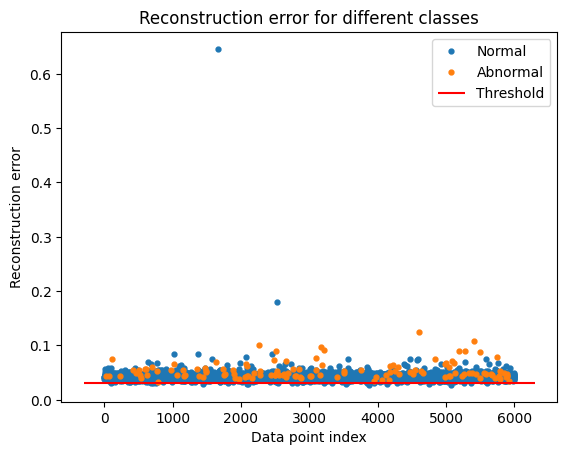

In [68]:
result = recon_err_plot(x_val, pred, y_val, .03)

In [69]:
result.head()

,index,Reconstruction_error,True_class
0,3178,0.042838,0
1,14926,0.041733,0
2,15116,0.039128,0
3,12733,0.041433,0
4,14032,0.047247,0


* precision_recall_f1_curve

<ipython-input-24-54b2435d894a>:3: RuntimeWarning: divide by zero encountered in true_divide
  f1 = 2 / (1/precision + 1/recall)


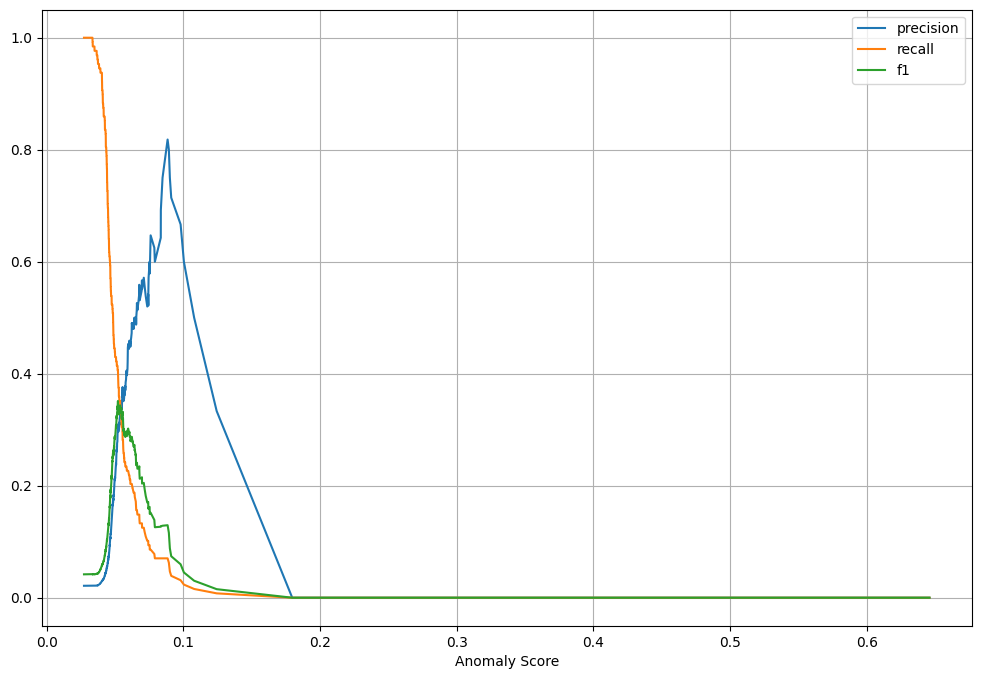

In [70]:
precision, recall, f1, thresholds = prec_rec_f1_curve(result['True_class'], 
                                                      result['Reconstruction_error'])

In [72]:
thresholds[np.argmax(f1)]

0.05219977153262256

* f1을 최대화 하는 threshold 값으로 평가

In [73]:
classification_report2(result['True_class'], result['Reconstruction_error'], 0.052)

< confusion matrix >

[[5750  122]
 [  76   52]]


< classification_report >

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      5872
           1       0.30      0.41      0.34       128

    accuracy                           0.97      6000
   macro avg       0.64      0.69      0.66      6000
weighted avg       0.97      0.97      0.97      6000

